In [ ]:
import os
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from typing import Annotated, Literal
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from langchain.tools import tool
from langgraph.types import Command
import requests
import random
import uuid


In [9]:
from dotenv import load_dotenv

In [10]:
load_dotenv()
fitness_api_key = os.getenv("NINJA_API_KEY")
diet_api_key = os.getenv("SPOONACULAR_API_KEY")

In [11]:
print(fitness_api_key)

WTH8f2OOuXryCeWfzCt3uQ==J1CpPrLT5wm690bd


Define State

In [12]:
class State(MessagesState):
    next: str

Create Fitness Tool

In [13]:
class FitnessData:

    def __init__(self):
        self.base_url = "https://api.api-ninjas.com/v1/exercises"
        self.api_key = fitness_api_key
       
    
    def get_muscle_groups_and_types(self):
     
        muscle_targets = {
                'full_body': ["abdominals", "biceps", "calves", "chest", "forearms", "glutes",
                    "hamstrings", "lower_back", "middle_back", "quadriceps",
                    "traps", "triceps", "adductors"
                    ],
                'upper_body': ["biceps", "chest", "forearms", "lats", "lower_back", "middle_back", "neck", "traps", "triceps" ],
                'lower_body': ["adductors", "calves", "glutes", "hamstrings", "quadriceps"]
            }
        exercise_types = {'types':["powerlifting","strength", "stretching", "strongman"]}

        return muscle_targets, exercise_types


    def fetch_exercises(self, type, muscle, difficulty):
        headers = {
            'X-Api-Key':self.api_key
        }
        params= {
            'type': type,
            'muscle': muscle,
            'difficulty': difficulty
            }
        try:
            response = requests.get(self.base_url, headers=headers,params=params)
            result = response.json()
            if not result:
                print(f"No exercises found for {muscle}")
            return result
        except requests.RequestException as e:
            print(f"Request failed: {e}")
            return []
        
       

    def generate_workout_plan(self, query='full_body', difficulty='intermediate'):
        output=[]
        muscle_targets, exercise_types = self.get_muscle_groups_and_types()
        muscle = random.choice(muscle_targets.get(query))
        type = random.choice(exercise_types.get('types'))
        result = self.fetch_exercises('stretching', muscle, difficulty)
        print(result)
        limit_plan = result[:3]
        for i, data in enumerate(limit_plan):
            if data not in output:
                output.append(f"Exercise {i+1}: {data['name']}")
                output.append(f"Muscle: {data['muscle']}")
                output.append(f"Instructions: {data['instructions']}")
              
        return output

In [14]:
@tool
def fitness_data_tool(query: Annotated[str, "This input will either be full_body, upper_body \
                                        or lower_body exercise plan"]):
    """use this tool to get fitness or workout plan for a user.
    The workout name provided serves as your input  \
                                        """
    fitness_tool = FitnessData()
    result = fitness_tool.generate_workout_plan(query)

    return result

In [16]:
fitness = FitnessData()
fitness.generate_workout_plan("full_body")

[{'name': 'Leg-Up Hamstring Stretch', 'type': 'stretching', 'muscle': 'hamstrings', 'equipment': 'body_only', 'difficulty': 'intermediate', 'instructions': "Lie flat on your back, bend one knee, and put that foot flat on the floor to stabilize your spine. Extend the other leg in the air. If you're tight, you wont be able to straighten it. That's okay. Extend the knee so that the sole of the lifted foot faces the ceiling (or as close as you can get it). Slowly straighten the legs as much as possible and then pull the leg toward your nose. Switch sides."}, {'name': 'Standing Toe Touches', 'type': 'stretching', 'muscle': 'hamstrings', 'equipment': 'None', 'difficulty': 'intermediate', 'instructions': 'Stand with some space in front and behind you. Bend at the waist, keeping your legs straight, until you can relax and let your upper body hang down in front of you. Let your arms and hands hang down naturally. Hold for 10 to 20 seconds.'}, {'name': 'Lying groin stretch with band', 'type': 's

['Exercise 1: Leg-Up Hamstring Stretch',
 'Muscle: hamstrings',
 "Instructions: Lie flat on your back, bend one knee, and put that foot flat on the floor to stabilize your spine. Extend the other leg in the air. If you're tight, you wont be able to straighten it. That's okay. Extend the knee so that the sole of the lifted foot faces the ceiling (or as close as you can get it). Slowly straighten the legs as much as possible and then pull the leg toward your nose. Switch sides.",
 'Exercise 2: Standing Toe Touches',
 'Muscle: hamstrings',
 'Instructions: Stand with some space in front and behind you. Bend at the waist, keeping your legs straight, until you can relax and let your upper body hang down in front of you. Let your arms and hands hang down naturally. Hold for 10 to 20 seconds.',
 'Exercise 3: Lying groin stretch with band',
 'Muscle: hamstrings',
 'Instructions: Lie on your back with your legs extended. Loop a belt, rope, or band around one of your feet, and swing that leg as f

Dietitian Tool

In [17]:
class Dietitian:

    def __init__(self):
        self.base_url = "https://api.spoonacular.com"
        self.api_key = diet_api_key
    
    def fetch_meal(self, time_frame="day", diet="None"):

        url = f"{self.base_url}/mealplanner/generate"
        params = {
            "timeFrame":time_frame,
            "diet": diet,
            "apiKey":self.api_key
        }

        response = requests.get(url, params=params)
        if not response:
            print('Meal Plan not found')
        return response.json()
    
    def get_recipe_information(self, recipe_id):

        url = f"{self.base_url}/recipes/{recipe_id}/information"
        params = {"apiKey": self.api_key}
        response = requests.get(url, params=params)
        if not response:
            print("Recipe not found")
        return response.json()


    def generate_meal_plan(self, query):
        meals_processed = []
        meal_plan = self.fetch_meal(query)
        print(meal_plan)
        
        meals = meal_plan.get('meals')
        nutrients = meal_plan.get('nutrients')

        for i, meal in enumerate(meals):
            recipe_info = self.get_recipe_information(meal.get('id'))
            ingredients = [ingredient['original'] for ingredient in recipe_info.get('extendedIngredients')]

            meals_processed.append(f"🍽️ Meal {i+1}: {meal.get('title')}")
            meals_processed.append(f"Prep Time: {meal.get('readyInMinutes')}")
            meals_processed.append(f"Servings: {meal.get('servings')}")
            
    
            meals_processed.append("📝 Ingredients:\n" + "\n".join(ingredients))
            meals_processed.append(f"📋 Instructions:\n {recipe_info.get('instructions')}")
            

        
        meals_processed.append( 
        "\n🔢 Daily Nutrients:\n"
        f"Protein: {nutrients.get('protein', 'N/A')} kcal\n"
        f"Fat: {nutrients.get('fat', 'N/A')} g\n"
        f"Carbohydrates: {nutrients.get('carbohydrates', 'N/A')} g"
        )


        return meals_processed


In [18]:
@tool
def diet_tool(query: Annotated[str, "This input will either be None, vegetarian, and vegan"]):
    """use this tool to get diet plan for the user.
    The diet type provided serves as your input  \
                                        """
    dietitian_tool = Dietitian()
    result = dietitian_tool.generate_meal_plan(query)

    return result

In [19]:
diet = Dietitian()
diet.generate_meal_plan("vegetarian")

{'meals': [{'id': 1100990, 'image': 'blueberry-chocolate-cocao-superfood-pancakes-gluten-free-paleo-vegan-1100990.jpg', 'imageType': 'jpg', 'title': 'Blueberry, Chocolate & Cocao Superfood Pancakes - Gluten-Free/Paleo/Vegan', 'readyInMinutes': 30, 'servings': 2, 'sourceUrl': 'https://www.foodista.com/recipe/35NX6PZB/blueberry-chocolate-cocao-superfood-pancakes-gluten-free-paleo-vegan'}, {'id': 650119, 'image': 'Linguine-Alla-Carbonara-650119.jpg', 'imageType': 'jpg', 'title': 'Linguine Alla Carbonara', 'readyInMinutes': 30, 'servings': 4, 'sourceUrl': 'https://www.foodista.com/recipe/X4N72XB2/linguine-alla-carbonara'}, {'id': 655573, 'image': 'Penne-Arrabiata-655573.jpg', 'imageType': 'jpg', 'title': 'Penne Arrabiata', 'readyInMinutes': 45, 'servings': 4, 'sourceUrl': 'https://www.foodista.com/recipe/2Y82DVJR/penne-arrabiata'}], 'nutrients': {'calories': 1969.28, 'protein': 59.67, 'fat': 76.51, 'carbohydrates': 265.34}}


['🍽️ Meal 1: Blueberry, Chocolate & Cocao Superfood Pancakes - Gluten-Free/Paleo/Vegan',
 'Prep Time: 30',
 'Servings: 2',
 '📝 Ingredients:\n1/2 cup almond flour\n1/2 cup coconut flour\n1 cup tapioca/arrowroot flour\n1 cup nut/hemp/coconut milk\n1 tsp. baking powder\n1 tsp. vanilla bean paste/extract\nPinch Himalayan sea salt\nHandful frozen blueberries\nHandful organic cacao nibs\nHandful of dark chocolate, roughly chopped',
 '📋 Instructions:\n <ol><li>Combine the almond, coconut, tapioca/arrowroot flour, baking powder, sugar and salt together and mix all the ingredients well before adding the milk and paste/extract and ensuring that all of the ingredients are whisked together to form a smooth batter.</li><li>Allow to sit for approximately 10-15 minutes.</li><li>Heat a small amount of coconut oil into a frying pan/skillet and pour a small enough amount of the batter into the middle of the pan.</li><li>Allow the batter to cook sufficiently for a few minutes (the edges should start to b

Define LLM and System Prompt

In [20]:
llm = ChatOllama(model="qwen2.5:14b")
memory = MemorySaver()

Creating the Agent

Build Fitness Agent

In [21]:
fitness_agent_prompt = """
You can only answer queries related to workout. 
"""


fitness_agent = create_react_agent(
    llm,
    tools = [fitness_data_tool],
    prompt = fitness_agent_prompt)


def fitness_node(state: State) -> Command[Literal["supervisor"]]:
    result = fitness_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="fitness")
            ]
        },
        goto="supervisor",
    )

Build Dietitian Agent

In [22]:
dietitian_system_prompt = """
You can only answer queries related to diet and meal plans.  .
"""
dietitian_agent = create_react_agent(
    llm,
    tools = [diet_tool],
    prompt = dietitian_system_prompt)


def dietitian_node(state: State) -> Command[Literal["supervisor"]]:
    result = dietitian_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="dietitian")
            ]
        },
        goto="supervisor",
    )

Mental Health Agent

In [23]:
def mental_health_node(state: State)-> Command[Literal["supervisor"]]:
    prompt = PromptTemplate.from_template(
        """You are a supportive mental wellness coach.
        Your task is to:
        - Give a unique mental wellness tip or stress-reducing practice.
        - Make it simple, kind, and useful. Avoid repeating tips."""
    )

    chain = prompt | llm
    response = chain.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=f"Here's your wellness tip: {response.content}", name="wellness")
            ]
        },
        goto="supervisor",
    )

Supervisor Agent

In [24]:
members = ["fitness", "dietitian", "wellness"]
options = members + ["FINISH"]



system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."


    "Guidelines:\n"
    "1. Always check the last message in the conversation to determine if the task has been completed.\n"
    "2. If you already have the final answer or outcome, return 'FINISH'.\n"
   
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

In [25]:
def supervisor_node(state: State)-> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

Build Supervisor Multi-Agent Graph

In [26]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("fitness", fitness_node)
builder.add_node("dietitian", dietitian_node)
builder.add_node("wellness", mental_health_node)
graph = builder.compile(checkpointer=memory)

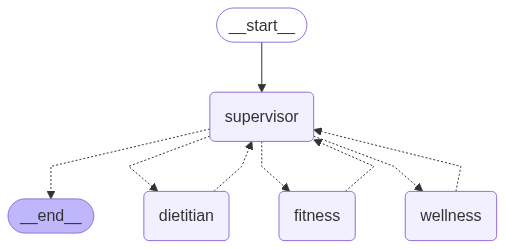

In [27]:
graph

Calling the Agents

In [28]:
def parse_langgraph_output(stream):
    results = []
    for key, value in stream.items():
        if key == "supervisor":
            continue
        messages = value.get("messages", [])
        for msg in messages:
            if isinstance(msg, str):
                results.append((key, msg))
            elif isinstance(msg, AIMessage):
                results.append((key, msg.content))
    return results

In [30]:
"Can you give me a daily routine that includes meals, workouts, and stress relief?"

'Can you give me a daily routine that includes meals, workouts, and stress relief?'

In [31]:
# Get the final step in the stream
final_event = None
config = {"configurable": {"thread_id": "1", "recursion_limit": 10}}    
inputs = {
                "messages": [
                    HumanMessage(
                        content="Give me wellness tips for the month?"
                    )
                ],
            }


for step in graph.stream(inputs, config=config):
    final_event = step  # Keep updating to the latest step
    print(final_event)

    response_message=parse_langgraph_output(final_event)
    for agent, content in response_message:
        print(f"**Agent :** `{agent}`\n\n{content}")
        print("="*50)

ConnectError: [WinError 10061] No connection could be made because the target machine actively refused it